**Name:** \_\_\_\_\_

**EID:** \_\_\_\_\_

# Tutorial 3: Face Detection in Images

In this tutorial you will train support vector machine and kernel support vector machine classifiers to detect whether there is a face in a small image patch.

First we need to initialize Python.  Run the below cell.

In [1]:
%matplotlib inline
import IPython.core.display
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import os
import zipfile
import fnmatch
random.seed(4487)
from scipy import ndimage
from scipy import signal
import skimage.color
import skimage.exposure
import skimage.io
import skimage.util

<ipython-input-1-2986c9138297>:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.core.display.set_matplotlib_formats("svg")


## 1. Loading Data and Pre-processing
Next we need to load the images.  Download `faces.zip`, and put it in the same direcotry as this ipynb file.  **Do not unzip the file.** Then run the following cell to load the images.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
imgdata = {'train':[], 'test':[]}
classes = {'train':[], 'test':[]}

# the dataset is too big, so subsample the training and test sets...
# reduce training set by a factor of 4
train_subsample = 4
train_counter = [0, 0]
# maximum number of samples in each class for test set
test_maxsample = 472
test_counter = [0, 0]

# load the zip file
filename = '/content/drive/MyDrive/tutorial/faces.zip' #'faces.zip'
zfile = zipfile.ZipFile(filename, 'r')

for name in zfile.namelist():
    # check file name matches
    if fnmatch.fnmatch(name, "faces/*/*/*.png"):

        # filename is : faces/train/face/fname.png
        (fdir1, fname)  = os.path.split(name)     # get file name
        (fdir2, fclass) = os.path.split(fdir1) # get class (face, nonface)
        (fdir3, fset)   = os.path.split(fdir2) # get training/test set
        # class 1 = face; class 0 = non-face
        myclass = int(fclass == "face")

        loadme = False
        if fset == 'train':
            if (train_counter[myclass] % train_subsample) == 0:
                loadme = True
            train_counter[myclass] += 1
        elif fset == 'test':
            if test_counter[myclass] < test_maxsample:
                loadme = True
            test_counter[myclass] += 1

        if (loadme):
            # open file in memory, and parse as an image
            myfile = zfile.open(name)
            #img = matplotlib.image.imread(myfile)
            img = skimage.io.imread(myfile)
            # convert to grayscale
            img = skimage.color.rgb2gray(skimage.color.rgba2rgb(img))
            myfile.close()

            # append data
            imgdata[fset].append(img)
            classes[fset].append(myclass)


zfile.close()
imgsize = img.shape

print(len(imgdata['train']))
print(len(imgdata['test']))
trainclass2start = sum(classes['train'])

1745
944


Each image is a 19x19 array of pixel values.  Run the below code to show an example:

(19, 19)


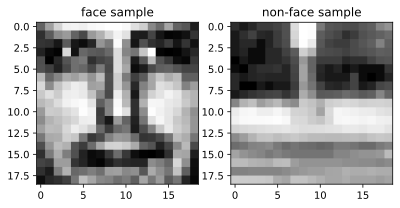

In [4]:
print(img.shape)
plt.subplot(1,2,1)
plt.imshow(imgdata['train'][0], cmap='gray', interpolation='nearest')
plt.title("face sample")
plt.subplot(1,2,2)
plt.imshow(imgdata['train'][trainclass2start], cmap='gray', interpolation='nearest')
plt.title("non-face sample")
plt.show()

Run the below code to show more images!

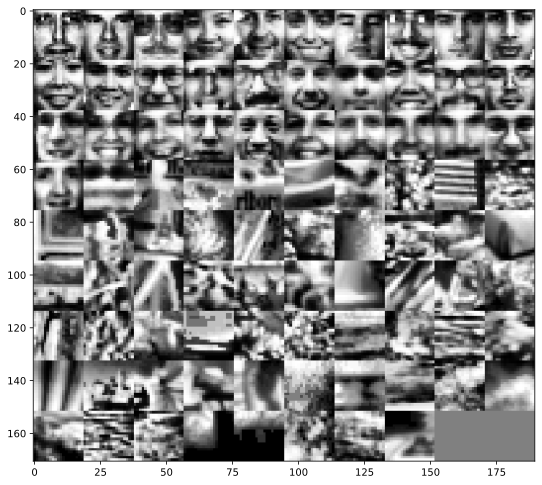

In [5]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)

    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])

    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)

    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2)
    return montimg

# show a few images
plt.figure(figsize=(9,9))
plt.imshow(image_montage(imgdata['train'][::20]), cmap='gray', interpolation='nearest')
plt.show()

Each image is a 2d array, but the classifier algorithms work on 1d vectors. Run the following code to convert all the images into 1d vectors by flattening.  The result should be a matrix where each row is a flattened image.

In [6]:
trainX = empty((len(imgdata['train']), prod(imgsize)))
for i,img in enumerate(imgdata['train']):
    trainX[i,:] = ravel(img)
trainY = asarray(classes['train'])  # convert list to numpy array
print(trainX.shape)
print(trainY.shape)

testX = empty((len(imgdata['test']), prod(imgsize)))
for i,img in enumerate(imgdata['test']):
    testX[i,:] = ravel(img)
testY = asarray(classes['test'])  # convert list to numpy array
print(testX.shape)
print(testY.shape)

(1745, 361)
(1745,)
(944, 361)
(944,)


## 2. Detection Using  Pixel Values

Train kernel SVM using either RBF or polynomia kernel classifiers to classify an image patch as face or non-face. Evaluate all classifiers on the test set.

Normalize the features and setup all the parameters and models.

In [7]:
# Normalization: sklearn.preprocessing.MinMaxScaler()
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXn = scaler.fit_transform(trainX)   # use training data to fit scaling parameters
testXn  = scaler.transform(testX)        # apply scaling to test data

clfs = {}

In [8]:
# setup all the parameters and models
exps = {
    'svm-lin': {
        'paramgrid': {'C': logspace(-2,3,10)},
        'clf': svm.SVC(kernel='linear') },
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,10), 'gamma': logspace(-4,3,10) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'C': logspace(-2,3,10), 'degree': [2, 3, 4] },
        'clf': svm.SVC(kernel='poly') },
    }

Try to train each classifier and show the parameters.

In [ ]:
### INSERT YOUR CODE HERE
## HINT
## 1. Classfiers: sklearn.model_selection.GridSearchCV()

In [9]:
# run the experiment
for (name,ex) in exps.items():
    print("=== " + name + " ===")
    if name in clfs:
        print("exists skipping")
    else:
        myclf = model_selection.GridSearchCV(ex['clf'], ex['paramgrid'], cv=5, verbose=1, n_jobs=-1)
        myclf.fit(trainXn, trainY)

        print("best params:", myclf.best_params_)

        clfs[name] = myclf

=== svm-lin ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best params: {'C': 0.01}
=== svm-rbf ===
Fitting 5 folds for each of 100 candidates, totalling 500 fits
best params: {'C': 1.6681005372000592, 'gamma': 0.021544346900318846}
=== svm-poly ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
best params: {'C': 5.994842503189409, 'degree': 2}


Calculate the training and test accuracy for the each classifier.

In [ ]:
### INSERT YOUR CODE HERE
## HINT
# 1. clf.predict()
# 2. metrics.accuracy_score()

In [10]:
### INSERT YOUR CODE HERE
predYtrain = {}
predYtest  = {}
for (name,clf) in clfs.items():
    predYtrain[name] = clf.predict(trainXn)
    predYtest[name]  = clf.predict(testXn)

    # calculate accuracy
    trainacc = metrics.accuracy_score(trainY, predYtrain[name])
    testacc  = metrics.accuracy_score(testY, predYtest[name])

    print("{:10s}: train={:.3f}; test={:.3f}".format(name, trainacc, testacc))

svm-lin   : train=0.983; test=0.643
svm-rbf   : train=1.000; test=0.658
svm-poly  : train=1.000; test=0.662


In [11]:
# set variables for later
predY = predYtest['svm-poly']
#adaclf = clfs['ada'].best_estimator_
svmclf_rbf = clfs['svm-rbf'].best_estimator_
svmclf_poly = clfs['svm-poly'].best_estimator_
#rfclf  = clfs['rf'].best_estimator_

_Which classifier was best?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- SVM polynomial

### Error analysis
The accuracy only tells part of the classifier's performance. We can also look at the different types of errors that the classifier makes:
- _True Positive (TP)_: classifier correctly said face
- _True Negative (TN)_: classifier correctly said non-face
- _False Positive (FP)_: classifier said face, but not a face
- _False Negative (FN)_: classifier said non-face, but was a face

This is summarized in the following table:

<table>
<tr><th colspan=2 rowspan=2><th colspan=2 style="text-align: center">Actual</th></tr>
<tr>  <th>Face</th><th>Non-face</th></tr>
<tr><th rowspan=2>Prediction</th><th>Face</th><td>True Positive (TP)</td><td>False Positive (FP)</td></tr>
<tr>  <th>Non-face</th><td>False Negative (FN)</td><td>True Negative (TN)</td></tr>
</table>

We can then look at the _true positive rate_ and the _false positive rate_.
- _true positive rate (TPR)_: proportion of true faces that were correctly detected
- _false positive rate (FPR)_: proportion of non-faces that were mis-classified as faces.

Use the below code to calculate the TPR and FPR of your classifiers.

In [12]:
# predY is the prediction from the classifier

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face

TP = count_nonzero(testY[Pind] == predY[Pind])
FN = count_nonzero(testY[Pind] != predY[Pind])
TN = count_nonzero(testY[Nind] == predY[Nind])
FP = count_nonzero(testY[Nind] != predY[Nind])

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)

print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
print("TPR=", TPR)
print("FPR=", FPR)

TP= 154
FP= 1
TN= 471
FN= 318
TPR= 0.326271186440678
FPR= 0.00211864406779661


_How does the classifier make errors?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- high TPR, means it gets all the faces.

For kernel SVM, we can look at the support vectors to see what the classifier finds difficult.

num support vectors: 307


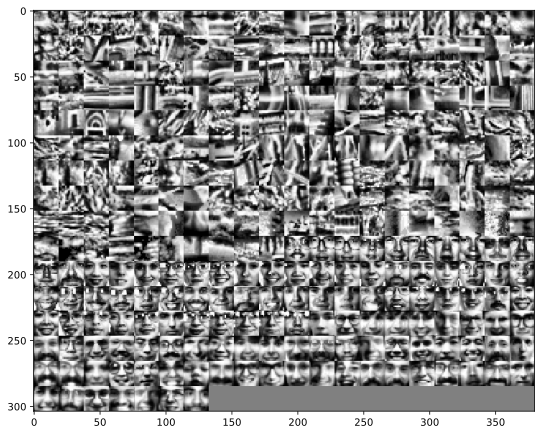

In [13]:
# svmclf is the trained SVM classifier

print("num support vectors:", len(svmclf_poly.support_vectors_))
si  = svmclf_poly.support_  # get indicies of support vectors

# get all the patches for each support vector
simg = [ imgdata['train'][i] for i in si ]

# make montage
outimg = image_montage(simg, maxw=20)

plt.figure(figsize=(9,9))
plt.imshow(outimg, cmap='gray', interpolation='nearest')

Comment on anything you notice about what the SVM finds difficult (i.e., on the decision boundary or within the margin)
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- glasses on faces.  some non-faces look like faces.

## 3. Detection using Image Feature

### Image Feature Extraction
The detection performance is not that good using pixel values. The problem is that we are using the raw pixel values as features, so it is difficult for the classifier to interpret larger structures of the face that might be important.  To fix the problem, we will extract features from the image using a set of filters.

Run the below code to look at the filter output.  The filters are a sets of black and white boxes that respond to similar structures in the image.  After applying the filters to the image, the filter response map is aggregated over a 4x4 window.  Hence each filter produces a 5x5 feature response.  Since there are 4 filters, then the feature vector is 100 dimensions.

In [14]:
def extract_features(imgs, doplot=False):
    # the filter layout
    lay = [array([-1,1]), array([-1,1,-1]),
               array([[1],[-1]]), array([[-1],[1],[-1]])]
    sc=8            # size of each filter patch
    poolmode = 'i'  # pooling mode (interpolate)
    cmode = 'same'  # convolution mode
    brick = ones((sc,sc))  # filter patch
    ks = []
    for l in lay:
        tmp = [brick*i for i in l]
        if (l.ndim==1):
            k = hstack(tmp)
        else:
            k = vstack(tmp)
        ks.append(k)

    # get the filter response size
    if (poolmode=='max') or (poolmode=='absmax'):
        tmpimg = maxpool(maxpool(imgs[0]))
    else:
        tmpimg = ndimage.interpolation.zoom(imgs[0], 0.25)
    fs = prod(tmpimg.shape)

    # get the total feature length
    fst = fs*len(ks)

    # filter the images
    X  = empty((len(imgs), fst))
    for i,img in enumerate(imgs):
        x = empty(fst)

        # for each filter
        for j,th in enumerate(ks):
            # filter the image
            imgk = signal.convolve(img, ks[j], mode=cmode)

            # do pooling
            if poolmode == 'maxabs':
                mimg = maxpool(maxpool(abs(imgk)))
            elif poolmode == 'max':
                mimg = maxpool(maxpool(imgk))
            else:
                mimg = ndimage.interpolation.zoom(imgk, 0.25)

            # put responses into feature vector
            x[(j*fs):(j+1)*fs] = ravel(mimg)

            if (doplot):
                plt.subplot(3,len(ks),j+1)
                plt.imshow(ks[j], cmap='gray', interpolation='nearest')
                plt.title("filter " + str(j))
                plt.subplot(3,len(ks),len(ks)+j+1)
                plt.imshow(imgk, cmap='gray', interpolation='nearest')
                plt.title("filtered image")
                plt.subplot(3,len(ks),2*len(ks)+j+1)
                plt.imshow(mimg, cmap='gray', interpolation='nearest')
                plt.title("image features")
        X[i,:] = x

    return X

<ipython-input-14-67585b19d239>:22: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  tmpimg = ndimage.interpolation.zoom(imgs[0], 0.25)
<ipython-input-14-67585b19d239>:44: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  mimg = ndimage.interpolation.zoom(imgk, 0.25)


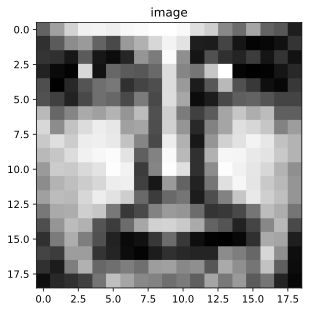

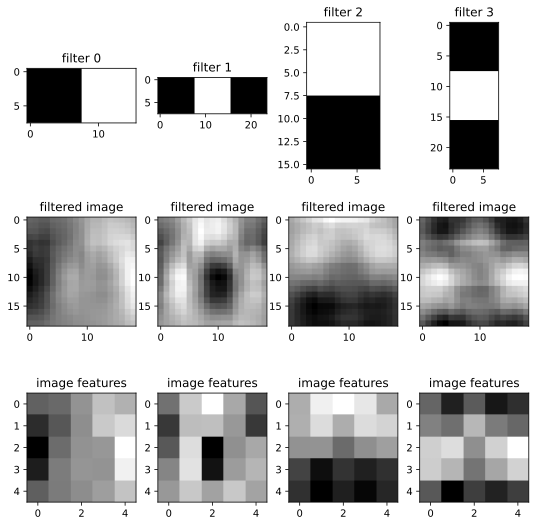

In [15]:
# new features
img = imgdata['train'][0]
plt.imshow(img, cmap='gray', interpolation='nearest')
plt.title("image")
plt.figure(figsize=(9,9))
extract_features([img], doplot=True);

Now lets extract image features on the training and test sets.  It may take a few seconds.

In [16]:
trainXf = extract_features(imgdata['train'])
print(trainXf.shape)
testXf = extract_features(imgdata['test'])
print(testXf.shape)

<ipython-input-14-67585b19d239>:22: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  tmpimg = ndimage.interpolation.zoom(imgs[0], 0.25)
<ipython-input-14-67585b19d239>:44: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  mimg = ndimage.interpolation.zoom(imgk, 0.25)


(1745, 100)
(944, 100)


### Detection
Now train AdaBoost and SVM classifiers on the image feature data.  Evaluate on the test set.

In [17]:
### Nomalization
scalerf = preprocessing.MinMaxScaler(feature_range=(-1,1))    # make scaling object
trainXfn = scalerf.fit_transform(trainXf)   # use training data to fit scaling parameters
testXfn  = scalerf.transform(testXf)        # apply scaling to test data

clfs2 = {}

In [18]:
# setup all the parameters and models
exps = {
    'svm-lin': {
        'paramgrid': {'C': logspace(-2,3,10)},
        'clf': svm.SVC(kernel='linear') },
    'svm-rbf': {
        'paramgrid': {'C': logspace(-2,3,10), 'gamma': logspace(-4,3,10) },
        'clf': svm.SVC(kernel='rbf') },
    'svm-poly': {
        'paramgrid': {'C': logspace(-2,3,10), 'degree': [2, 3, 4] },
        'clf': svm.SVC(kernel='poly') },
    }
clfs2 = {}

Try to train each classifier and show the parameters.

In [ ]:
### INSERT YOUR CODE HERE
## HINT
## Classfiers: sklearn.model_selection.GridSearchCV()

In [19]:
### INSERT YOUR CODE HERE
# run the experiment
for (name,ex) in exps.items():
    print("=== " + name + " ===")
    if name in clfs2:
        print("exists skipping")
    else:
        myclf = model_selection.GridSearchCV(ex['clf'], ex['paramgrid'], cv=5, verbose=1, n_jobs=-1)
        myclf.fit(trainXfn, trainY)

        print("best params:", myclf.best_params_)

        clfs2[name] = myclf

=== svm-lin ===
Fitting 5 folds for each of 10 candidates, totalling 50 fits
best params: {'C': 5.994842503189409}
=== svm-rbf ===
Fitting 5 folds for each of 100 candidates, totalling 500 fits
best params: {'C': 278.2559402207126, 'gamma': 0.021544346900318846}
=== svm-poly ===
Fitting 5 folds for each of 30 candidates, totalling 150 fits
best params: {'C': 21.544346900318846, 'degree': 2}


Calculate the training and test accuracy for the each classifier.

In [ ]:
### INSERT YOUR CODE HERE

In [20]:
### INSERT YOUR CODE HERE
# Hint: Refer to last tutoiral
predYtrain = {}
predYtest  = {}
for (name,clf) in clfs2.items():
    predYtrain[name] = clf.predict(trainXfn)
    predYtest[name]  = clf.predict(testXfn)

    # calculate accuracy
    trainacc = metrics.accuracy_score(trainY, predYtrain[name])
    testacc  = metrics.accuracy_score(testY, predYtest[name])

    print("{:10s}: train={:.3f}; test={:.3f}".format(name, trainacc, testacc))

svm-lin   : train=0.962; test=0.713
svm-rbf   : train=0.998; test=0.734
svm-poly  : train=0.991; test=0.754


In [21]:
testY = predYtest['svm-rbf']
bestclf = clfs2['svm-rbf']

### Error Analysis
Similar to before, repeat the error analysis for the new classifiers.

In [ ]:
### INSERT YOUR CODE HERE


In [22]:
### INSERT YOUR CODE HERE

Pind = where(testY==1) # indicies for face
Nind = where(testY==0) # indicies for non-face
TP = sum(testY[Pind] == predY[Pind])
FN = sum(testY[Pind] != predY[Pind])
TN = sum(testY[Nind] == predY[Nind])
FP = sum(testY[Nind] != predY[Nind])


TPR = TP / (TP+FN)
FPR = FP / (FP+TN)

print("TP=", TP)
print("FP=", FP)
print("TN=", TN)
print("FN=", FN)
print("TPR=", TPR)
print("FPR=", FPR)

TP= 137
FP= 18
TN= 679
FN= 110
TPR= 0.5546558704453441
FPR= 0.02582496413199426


How has the classifier using image features improved?
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- higher TPR but lower FPR

# Test image
Now let us try your face detector on a real image.  Download the "nasa-small.png" image and put it in the same directory as your ipynb file.  The below code will load the image, crop out image patches and then extract features. (this may take a few minutes)

In [27]:
fname = '/content/drive/MyDrive/tutorial/nasa-small.png'

(210, 480)


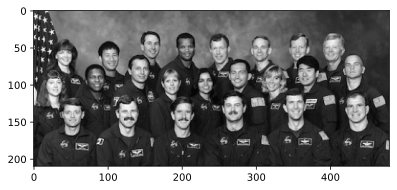

In [28]:
# load image
testimg3 = skimage.io.imread(fname)

# convert to grayscale
#testimg = skimage.color.rgb2gray(testimg3)
testimg = skimage.color.rgb2gray(skimage.color.rgba2rgb(testimg3))
print(testimg.shape)
plt.imshow(testimg, cmap='gray')

In [29]:
# step size for the sliding window
step = 4

# extract window patches with step size of 4
patches = skimage.util.view_as_windows(testimg, (19,19), step=step)
psize = patches.shape
print(psize)
# collapse the first 2 dimensions
patches2 = patches.reshape((psize[0]*psize[1], psize[2], psize[3]))
print(patches2.shape )

# histogram equalize patches (improves contrast)
patches3 = empty(patches2.shape)
for i in range(patches2.shape[0]):
    patches3[i,:,:] = skimage.exposure.equalize_hist(patches2[i,:,:])

# extract features
newXf = extract_features(patches3)

(48, 116, 19, 19)
(5568, 19, 19)


<ipython-input-14-67585b19d239>:22: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  tmpimg = ndimage.interpolation.zoom(imgs[0], 0.25)
<ipython-input-14-67585b19d239>:44: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  mimg = ndimage.interpolation.zoom(imgk, 0.25)


Now predict using your classifier.  The extracted features are in `newXf`.

In [ ]:
### INSERT YOUR CODE HERE
## HINT
## 1. Apply scaling to test data

In [30]:
### INSERT YOUR CODE HERE
newXfn  = scalerf.transform(newXf)        # apply scaling to test data
prednewY = bestclf.predict(newXfn)

Now we we will view the results on the image.  Use the below code. `prednewY` is the vector of predictions.

<ipython-input-31-d14e29babf40>:5: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)


(-0.5, 479.5, 209.5, -0.5)

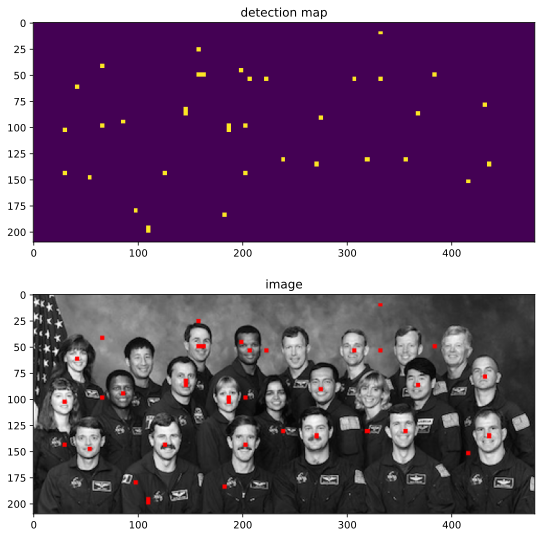

In [31]:
# reshape prediction to an image
imgY = prednewY.reshape(psize[0], psize[1])

# zoom back to image size
imgY2 = ndimage.interpolation.zoom(imgY, step, output=None, order=0)
# pad the top and left with half the window size
imgY2 = vstack((zeros((9, imgY2.shape[1])), imgY2))
imgY2 = hstack((zeros((imgY2.shape[0],9)), imgY2))
# pad right and bottom to same size as image
if (imgY2.shape[0] != testimg.shape[0]):
    imgY2 = vstack((imgY2, zeros((testimg.shape[0]-imgY2.shape[0], imgY2.shape[1]))))
if (imgY2.shape[1] != testimg.shape[1]):
    imgY2 = hstack((imgY2, zeros((imgY2.shape[0],testimg.shape[1]-imgY2.shape[1]))))

# show detections with image
#detimg = dstack(((0.5*imgY2+0.5)*testimg, 0.5*testimg, 0.5*testimg))
nimgY2 = 1-imgY2
tmp = nimgY2*testimg
detimg = dstack((imgY2+tmp, tmp, tmp))

# show it!
plt.figure(figsize=(9,9))
plt.subplot(2,1,1)
plt.imshow(imgY2, interpolation='nearest')
plt.title('detection map')
plt.subplot(2,1,2)
plt.imshow(detimg)
plt.title('image')
plt.axis('image')

_How did your face detector do?_
- **INSERT YOUR ANSWER HERE**

- **INSERT YOUR ANSWER HERE**
- got some faces, but also had lots of FP!

- You can try it on your own images.  The faces should all be around 19x19 pixels though.
- We only used 1/4 of the training data. Try using more data to train it!